## Цель исследования: оценить изменение затрачиваемого времени на предварительное и финальное рассмотрение заявок

In [129]:
import pandas as pd
pd.set_option('display.max_columns', None) 
import pathlib
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

#from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split

#from sklearn.linear_model import Lasso, Ridge
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [130]:
path = pathlib.Path('C:/') / 'Ya' / 'datas' / 'vd_data' / 'df_for_time.csv'
print(path)  
df = pd.read_csv(path)
df.head()

C:\Ya\datas\vd_data\df_for_time.csv


,Unnamed: 0,app_id,application_date,client_id,requested_product_line,decision,minutes_preliminary_decision,minutes_final_decision,branch_id
0,0,71616,13.06.2014,99000008428,Потребительское кредитование,Одобрена,3.36,NaN,41.0
1,1,71617,13.06.2014,99000008430,Потребительское кредитование,Одобрена,25.10,NaN,41.0
2,2,177517,15.06.2014,99000008435,Потребительское кредитование,Заявка отклонена,22.00,NaN,41.0
3,3,71618,16.06.2014,99000008439,Потребительское кредитование,Одобрена,31.08,NaN,41.0
4,4,177518,16.06.2014,99000008440,Потребительское кредитование,Одобрена,NaN,NaN,41.0


In [131]:
#посмортим на количество пропусков 
df.isna().mean()

Unnamed: 0                      0.000000
app_id                          0.000000
application_date                0.000000
client_id                       0.000000
requested_product_line          0.005044
decision                        0.066266
minutes_preliminary_decision    0.037716
minutes_final_decision          0.349744
branch_id                       0.000025
dtype: float64

**Вывод:**

В срезе данных за 21 и 22 год - 13 % пропусков в поле minutes_final_decision 

In [132]:
#переводим дату в удобный формат
df['application_date'] = pd.to_datetime(df['application_date'], format='%d.%m.%Y')

#берём данные только за 21й и 22й год
df = df.query('application_date >= "01.01.2021"')

# удаляем строки без времени финального решения
df = df.dropna(subset=['minutes_final_decision'])

# так как по условию нас интересуют только данные по заемам наличными, делаем ещё один срез
df = df.query('requested_product_line != "Потребительское кредитование"')

# создаём поле с флагими: 1 - одобрен; 0 - заявка отклонена, либо пропуск
def test_4_decision(cell_value):
    if cell_value == 'Одобрена': return 1
    return 0
df['decision_flag'] = df['decision'].apply(test_4_decision)

# оставляем нужные нам поля
df = (df[['app_id', 'application_date', 'client_id', 'minutes_preliminary_decision'
         , 'minutes_final_decision', 'branch_id', 'decision_flag' ]]
     )

#добаляем поле с месяцем для последующей группировки
df['month'] = df['application_date'].dt.to_period('M')

# выводим информацию о датасете на экран
display(df.head())
print()
display(df.info())

# проверяем на наличие дубликатов
print()
print('кол-во дубликатов = ', df.duplicated().sum())



,app_id,application_date,client_id,minutes_preliminary_decision,minutes_final_decision,branch_id,decision_flag,month
421460,412643,2021-01-02,99000228200,15.12,0.42,419.0,0,2021-01
421467,412650,2021-01-02,99000002541,46.18,0.51,449.0,1,2021-01
421470,412653,2021-01-02,99000111548,23.45,2.20,30.0,1,2021-01
421475,412658,2021-01-02,99000173000,37.24,1.28,473.0,1,2021-01
421477,412660,2021-01-02,99000228205,9.06,0.12,419.0,0,2021-01



<class 'pandas.core.frame.DataFrame'>
Int64Index: 72000 entries, 421460 to 590961
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   app_id                        72000 non-null  int64         
 1   application_date              72000 non-null  datetime64[ns]
 2   client_id                     72000 non-null  int64         
 3   minutes_preliminary_decision  72000 non-null  float64       
 4   minutes_final_decision        72000 non-null  float64       
 5   branch_id                     72000 non-null  float64       
 6   decision_flag                 72000 non-null  int64         
 7   month                         72000 non-null  period[M]     
dtypes: datetime64[ns](1), float64(3), int64(3), period[M](1)
memory usage: 4.9 MB


None


кол-во дубликатов =  0


### Выясним, как меняется среднее время рассмотрения заявоек по месяцам

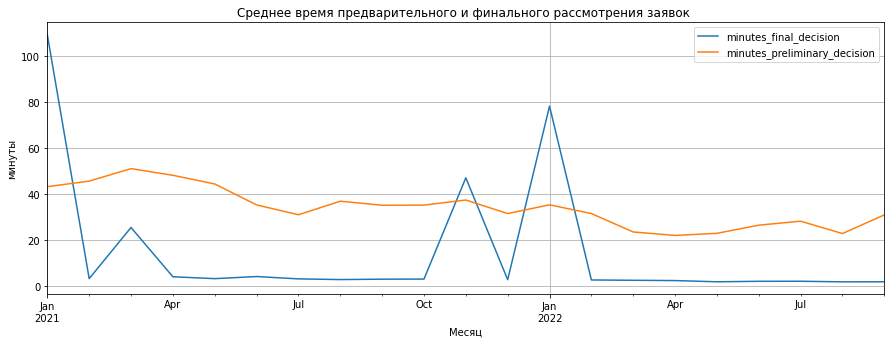

In [133]:
(
     df
    .pivot_table(index='month', values=['minutes_preliminary_decision', 'minutes_final_decision'], aggfunc='mean')
    .plot(grid=True, figsize=(15, 5))
)
plt.title('Среднее время предварительного и финального рассмотрения заявок ')
plt.xlabel('Месяц')
plt.ylabel('минуты')
plt.show()

**Вывод:**

Резкое увеличение среднего времени финального решения по заявке наблюдалось в январе, марте и ноябре 2021-го года, а также в январе 2022-го.

По среднему показателю трудно оценить с чем это связано, посмотрим на диаграмму размаха значений, он же "ящик с усами".

### Строим диаграмму размаха по времени финального решения чтобы оценить наличие выбросов

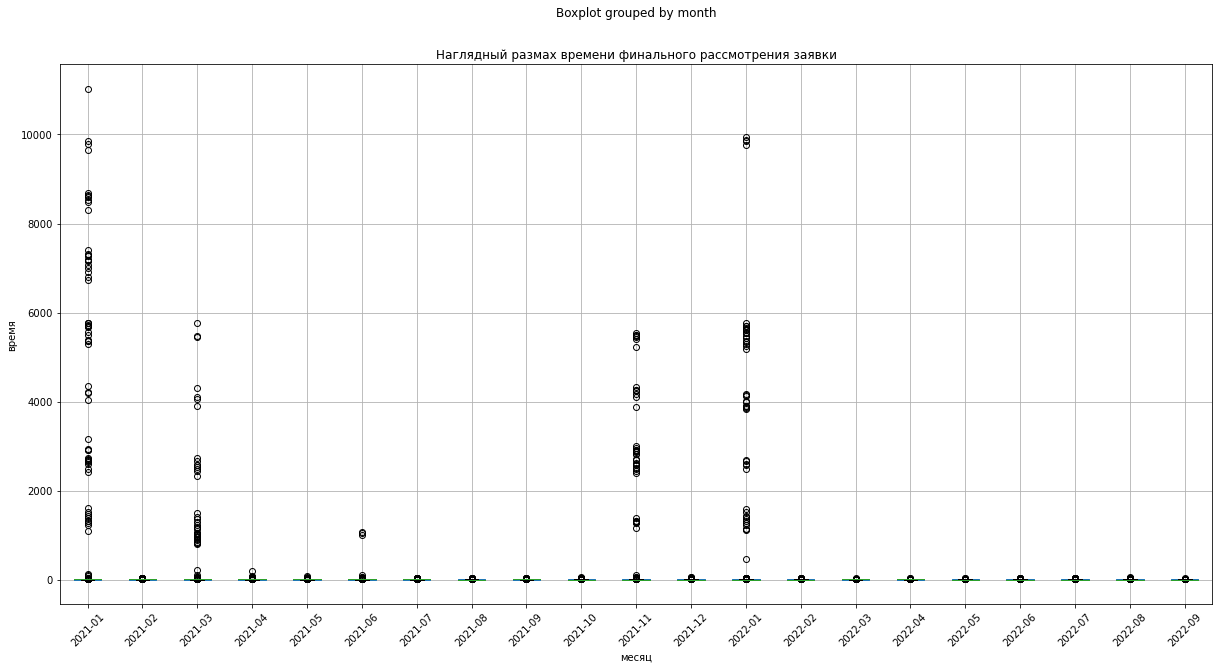

In [134]:
# задаём параметры для оформления диаграмм размаха
(
    df
    .boxplot(column='minutes_final_decision', by='month', figsize=(20,10))
)
#plt.ylim(-1, 200)
plt.title('Наглядный размах времени финального рассмотрения заявки')
plt.ylabel('время')
plt.xlabel('месяц')
plt.xticks(rotation=45)
plt.show()

**Вывод:**

Очевидно, что резкие скачки среднего времени принятия финального решения связаны с выбросами в данных. Как можем видеть в что в озвученных выше месяцах, числятся такие заявки, на финиальное решение по которым затрачивалось более 5 суток (8 000 минут и более).

Необходимо выяснить причину выгрузки подобных данных, а также на сколько они правдивы и нет ли системной ошибки при их выгрузке.

### Также построим диаграмму размаха по времени предварительного решения

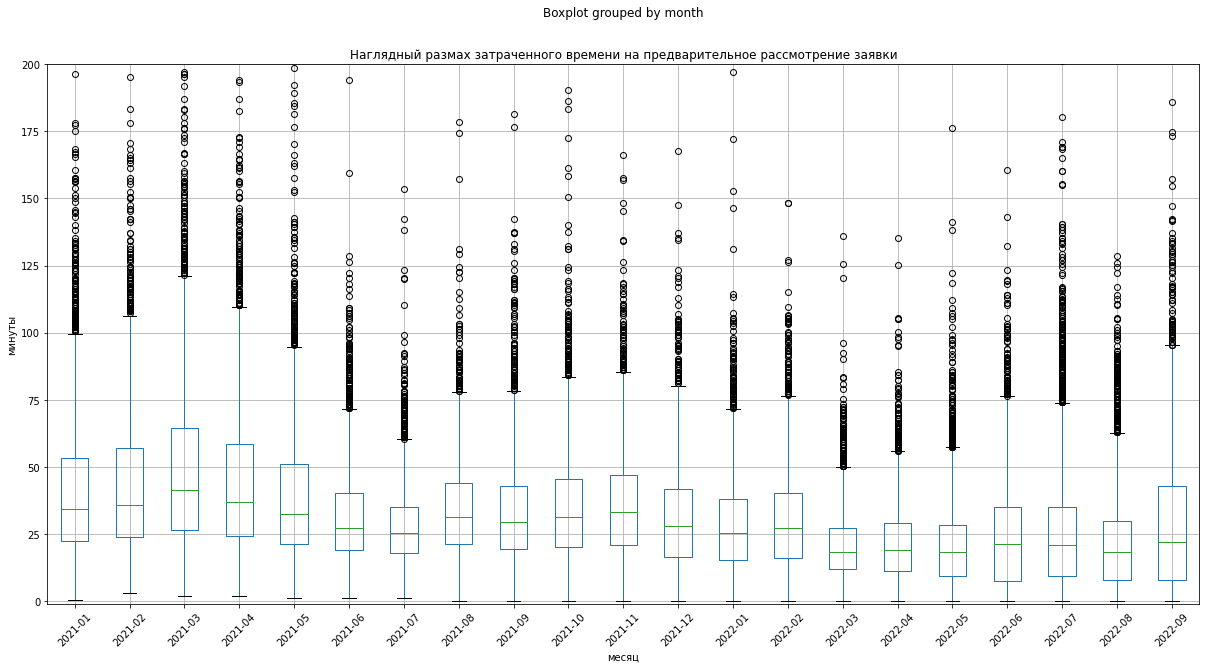

In [135]:
(
    df
    .boxplot(column='minutes_preliminary_decision', by='month', figsize=(20,10))
)
plt.ylim(-1, 200)
plt.title('Наглядный размах затраченного времени на предварительное рассмотрение заявки')
plt.ylabel('минуты')
plt.xlabel('месяц')
plt.xticks(rotation=45)
plt.show()

### Для дальнейшей адекватной оценки скорости одобрения заявок, рассмотрим медианные значения

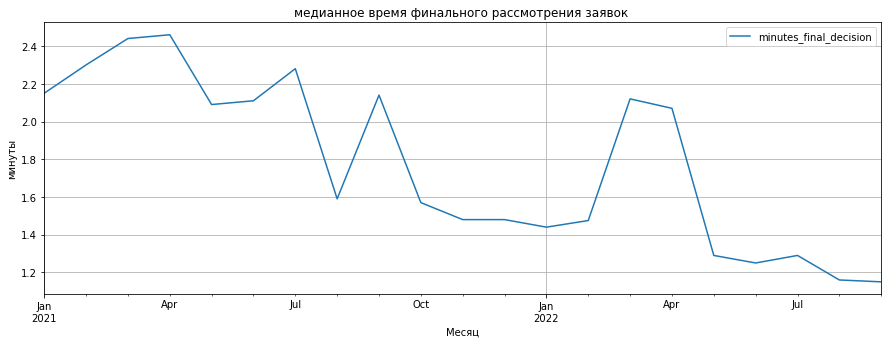

In [136]:
(
     df
    .pivot_table(index='month', values=['minutes_final_decision'], aggfunc='median')
    .plot(grid=True, figsize=(15, 5))
)
plt.title('медианное время финального рассмотрения заявок ')
plt.xlabel('Месяц')
plt.ylabel('минуты')
plt.show()

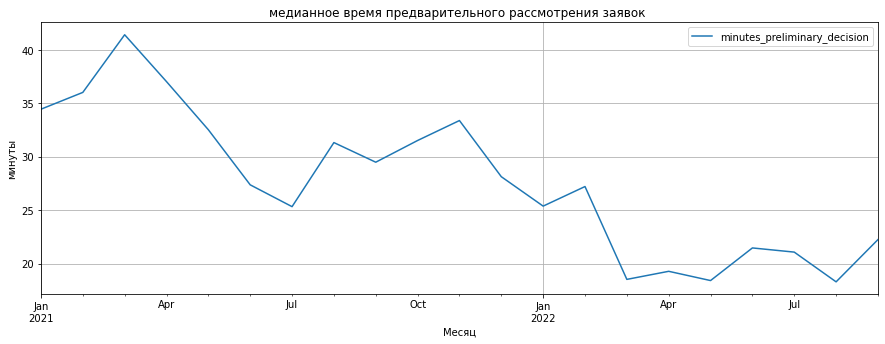

In [137]:
(
     df
    .pivot_table(index='month', values=['minutes_preliminary_decision'], aggfunc='median')
    .plot(grid=True, figsize=(15, 5))
)
plt.title('медианное время предварительного рассмотрения заявок ')
plt.xlabel('Месяц')
plt.ylabel('минуты')
plt.show()

### Общий вывод:

- В срезе данных за 21 и 22 год - 13 % пропусков в поле minutes_final_decision;

На основании 72 000 рассмотренных заявок, было обнаружено слудующее:
 - для данных о времени финального одобрения характерны странные значения - выбросы. Например, в январе, марте и ноябре 2021-го года, а также в январе 2022-го можем наблюдать такие заявки, на финиальное решение по которым затрачивалось более 5 суток (8 000 минут и более). Необходимо выяснить причину выгрузки подобных данных, а также на сколько они правдивы и нет ли системной ошибки при их выгрузке;
 - из-за этих выбросов для оценки изменения финального времени согласования заявки рассматривал медианные значения;
 - в марте 22го года наблюдалось увеличение времени финального рассмотрения заявок до 2х минут 6ти секунд, но уже к началу мая этот показатель снизился до 1 минуты 18 секунд. С августа 22-го года, время финального рассмотрения показывает рекордную скорость в районе 1-й минуты;
 - предварительное время рассмотрения заявок резко снизилось к марту 22го года до 10 минут, к началу лета увеличилось до 21 минуты, к концу лета, оно вернулось к 10 минутам, а с августа наблюдается незначительный рост до 22х минут. 
